## __Transfer Learning Using Flowers DB and the Pre-trained MobileNet Algorithm__

In [3]:
# Importing PlaidML
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [15]:
!pip install --upgrade tensorflow_hub

     |████████████████████████████████| 107 kB 4.5 MB/s eta 0:00:01
You should consider upgrading via the '/Users/nicksbox/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [16]:
#import packages
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [6]:
#download flowers dataset from tensorflow: Split Train/Test
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)



Dataset tf_flowers downloaded and prepared to /Users/nicksbox/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
#view information about dataset
num_classes = dataset_info.features['label'].num_classes
num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [8]:
#check details of flower dataset
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [9]:
#reformat inputs and batches to be used by Mobilenet
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [17]:
#create feature extractor
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [18]:
#freeze layers of image res model
feature_extractor.trainable = False

In [19]:
#create model using pre-trained model and learning classification layer
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
#train model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                   epochs=EPOCHS,
                   validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 34s 404ms/step - loss: 1.0409 - accuracy: 0.5949 - val_loss: 0.4411 - val_accuracy: 0.8501
Epoch 2/6
81/81 [==============================] - 33s 412ms/step - loss: 0.3691 - accuracy: 0.8811 - val_loss: 0.3724 - val_accuracy: 0.8710
Epoch 3/6
81/81 [==============================] - 33s 405ms/step - loss: 0.3034 - accuracy: 0.9036 - val_loss: 0.3382 - val_accuracy: 0.8856
Epoch 4/6
81/81 [==============================] - 33s 404ms/step - loss: 0.2358 - accuracy: 0.9273 - val_loss: 0.3128 - val_accuracy: 0.8955
Epoch 5/6
81/81 [==============================] - 32s 402ms/step - loss: 0.2012 - accuracy: 0.9474 - val_loss: 0.3022 - val_accuracy: 0.9001
Epoch 6/6
81/81 [==============================] - 33s 403ms/step - loss: 0.1801 - accuracy: 0.9563 - val_loss: 0.2972 - val_accuracy: 0.9064


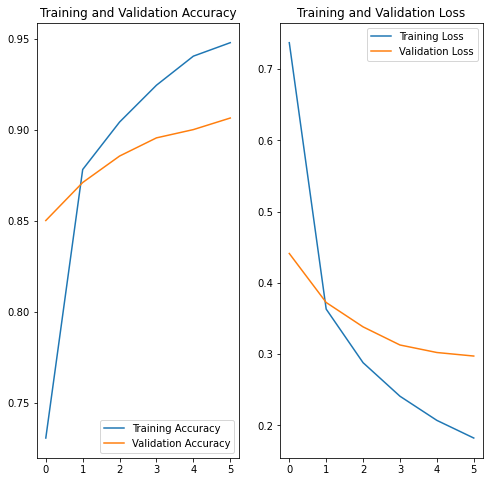

In [23]:
#show performance of model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#check predictions
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [26]:
#create image batches for predictions
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['tulips' 'tulips' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'dandelion' 'tulips' 'dandelion' 'sunflowers' 'dandelion' 'roses' 'roses'
 'tulips' 'dandelion' 'dandelion' 'dandelion' 'dandelion' 'sunflowers'
 'dandelion' 'dandelion' 'tulips' 'sunflowers' 'sunflowers' 'dandelion'
 'sunflowers' 'roses' 'dandelion' 'sunflowers' 'dandelion' 'tulips'
 'tulips']


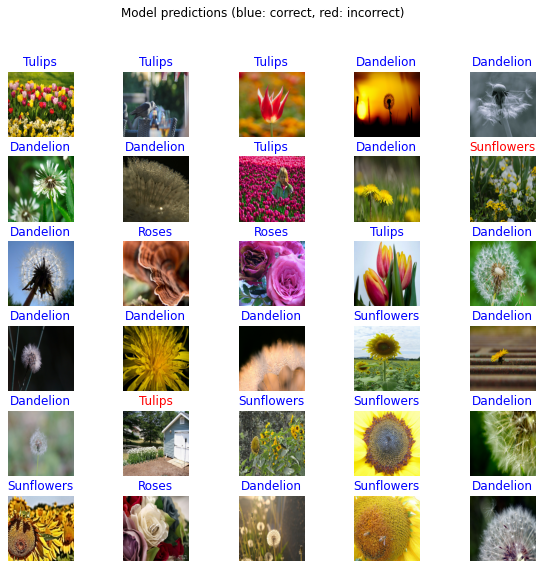

In [27]:
#make predictions

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")